In [1]:
#Import necessary libraries, some libraries need to imported using conda or pip install
import os
import cv2
import time
import shutil
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
sns.set_style('darkgrid')
from sklearn.utils.class_weight import compute_class_weight
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax

from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.models import Model, load_model, Sequential
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
print ('modules loaded')



Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2024-03-03 20:46:14.346781: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


modules loaded


In [2]:

def define_paths(dir):
    folds = os.listdir(dir)
    files =[]
    classes = []
    for fold in folds:
        foldpath = os.path.join(dir, fold)
        #check if it's a directotory before trying to list its contents
        if os.path.isdir(foldpath):
            filelist = os.listdir(foldpath)
            for file in filelist:
                fpath = os.path.join(foldpath,file)
                files.append(fpath)
                classes.append(fold)
    return files, classes

def define_df(files, classes):
    
    Fseries = pd.Series(files, name= 'filepaths') 

    Lseries = pd.Series(classes, name='labels') 

    return pd.concat([Fseries, Lseries], axis= 1) 


def create_df(tr_dir, val_dir, ts_dir): 

    # train dataframe 

    files, classes = define_paths(tr_dir) 

    train_df = define_df(files, classes) 

    # validation dataframe 

    files, classes = define_paths(val_dir) 

    valid_df = define_df(files, classes) 

    # test dataframe 

    files, classes = define_paths(ts_dir) 

    test_df = define_df(files, classes) 

    return train_df, valid_df, test_df 

In [3]:
def create_gens(train_df, valid_df, test_df, batch_size):
    img_size = (224, 224)
    channels = 3
    img_shape = (img_size[0], img_size[1], channels)
    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length % n == 0 and ts_length / n <= 80]))
    test_steps = ts_length // test_batch_size



    
    def scalar(img):
        return img

    tr_gen = ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True, vertical_flip=True)
    ts_gen = ImageDataGenerator(preprocessing_function=scalar)

    # Calculate class weights
    y_train = train_df['labels'].values
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
    class_weights = dict(enumerate(class_weights))  # Convert to dictionary for ImageDataGenerator

    train_gen = tr_gen.flow_from_dataframe(
        train_df,
        x_col='filepaths',
        y_col='labels',
        target_size=img_size,
        class_mode='categorical',
        color_mode='rgb',
        shuffle=True,
        batch_size=batch_size,
        class_weight=class_weights
    )

    valid_gen = ts_gen.flow_from_dataframe(
        valid_df,
        x_col='filepaths',
        y_col='labels',
        target_size=img_size,
        class_mode='categorical',
        color_mode='rgb',
        shuffle=True,
        batch_size=batch_size
    )

    test_gen = ts_gen.flow_from_dataframe(
        test_df,
        x_col='filepaths',
        y_col='labels',
        target_size=img_size,
        class_mode='categorical',
        color_mode='rgb',
        shuffle=False,
        batch_size=test_batch_size
    )

    return train_gen, valid_gen, test_gen


In [4]:
def show_images(gen):
    g_dict = gen.class_indices        # defines dictionary {'class': index}
    classes = list(g_dict.keys())     # defines list of dictionary's kays (classes)
    images, labels = next(gen)        # get a batch size samples from the generator
    plt.figure(figsize= (20, 20))
    length = len(labels)              # length of batch size
    sample = min(length, 25)          # check if sample less than 25 images
    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] /255.0   
        plt.imshow(image)
        index = np.argmax(labels[i])  # get image index
        class_name = classes[index]   # get class of image
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

In [5]:
class MyCallback(keras.callbacks.Callback):
    def __init__(self, model, base_model, patience, stop_patience, threshold, factor, dwell, batches, initial_epoch, epochs, ask_epoch):
        super(MyCallback, self).__init__()
        self.model = model
        self.base_model = base_model
        self.patience = patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience = stop_patience # specifies how many times to adjust lr without improvement to stop training
        self.threshold = threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor = factor # factor by which to reduce the learning rate
        self.dwell = dwell
        self.batches = batches # number of training batch to runn per epoch
        self.initial_epoch = initial_epoch
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch # save this value to restore if restarting training
        # callback variables
        self.count = 0 # how many times lr has been reduced without improvement
        self.stop_count = 0
        self.best_epoch = 1   # epoch with the lowest loss
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initial learning rate and save it
        self.highest_tracc = 0.0 # set highest training accuracy to 0 initially
        self.lowest_vloss = np.inf # set lowest validation loss to infinity initially
        self.best_weights = self.model.get_weights() # set best weights to model's initial weights
        self.initial_weights = self.model.get_weights()   # save initial weights if they have to get restored

    # Define a function that will run when train begins
    def on_train_begin(self, logs= None):
        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
        print(msg)
        self.start_time = time.time()

    def on_train_end(self, logs= None):
        stop_time = time.time()
        tr_duration = stop_time - self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print(msg)
        self.model.set_weights(self.best_weights) # set the weights of the model to the best weights

    def on_train_batch_end(self, batch, logs= None):
        acc = logs.get('accuracy') * 100 # get batch accuracy
        loss = logs.get('loss')
        msg = '{0:20s}processing batch {1:} of {2:5s}-   accuracy=  {3:5.3f}   -   loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end= '') # prints over on the same line to show running batch count

    def on_epoch_begin(self, epoch, logs= None):
        self.ep_start = time.time()

    # Define method runs on the end of each epoch
    def on_epoch_end(self, epoch, logs= None):
        ep_end = time.time()
        duration = ep_end - self.ep_start

        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        current_lr = lr
        acc = logs.get('accuracy')  # get training accuracy
        v_acc = logs.get('val_accuracy')  # get validation accuracy
        loss = logs.get('loss')  # get training loss for this epoch
        v_loss = logs.get('val_loss')  # get the validation loss for this epoch

        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor = 'accuracy'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (acc - self.highest_tracc ) * 100 / self.highest_tracc # define improvement of model progres

            if acc > self.highest_tracc: # training accuracy improved in the epoch
                self.highest_tracc = acc # set new highest training accuracy
                self.best_weights = self.model.get_weights() # training accuracy improved so save the weights
                self.count = 0 # set count to 0 since training accuracy improved
                self.stop_count = 0 # set stop counter to 0
                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
                self.best_epoch = epoch + 1  # set the value of best epoch for this epoch

            else:
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count >= self.patience - 1: # lr should be adjusted
                    lr = lr * self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    self.count = 0 # reset the count to 0
                    self.stop_count = self.stop_count + 1 # count the number of consecutive lr adjustments
                    self.count = 0 # reset counter
                    if self.dwell:
                        self.model.set_weights(self.best_weights) # return to better point in N space
                    else:
                        if v_loss < self.lowest_vloss:
                            self.lowest_vloss = v_loss
                else:
                    self.count = self.count + 1 # increment patience counter

        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor = 'val_loss'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (self.lowest_vloss - v_loss ) * 100 / self.lowest_vloss
            if v_loss < self.lowest_vloss: # check if the validation loss improved
                self.lowest_vloss = v_loss # replace lowest validation loss with new validation loss
                self.best_weights = self.model.get_weights() # validation loss improved so save the weights
                self.count = 0 # reset count since validation loss improved
                self.stop_count = 0
                self.best_epoch = epoch + 1 # set the value of the best epoch to this epoch
            else: # validation loss did not improve
                if self.count >= self.patience - 1: # need to adjust lr
                    lr = lr * self.factor # adjust the learning rate
                    self.stop_count = self.stop_count + 1 # increment stop counter because lr was adjusted
                    self.count = 0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    if self.dwell:
                        self.model.set_weights(self.best_weights) # return to better point in N space
                else:
                    self.count = self.count + 1 # increment the patience counter
                if acc > self.highest_tracc:
                    self.highest_tracc = acc

        msg = f'{str(epoch + 1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc * 100:^9.3f}{v_loss:^9.5f}{v_acc * 100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print(msg)

        if self.stop_count > self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg = f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print(msg)
            self.model.stop_training = True # stop training

        else:
            if self.ask_epoch != None:
                if epoch + 1 >= self.ask_epoch:
                    msg = 'enter H to halt training or an integer for number of epochs to run then ask again'
                    print(msg)
                    ans = input('')
                    if ans == 'H' or ans == 'h':
                        msg = f'training has been halted at epoch {epoch + 1} due to user input'
                        print(msg)
                        self.model.stop_training = True # stop training
                    else:
                        try:
                            ans = int(ans)
                            self.ask_epoch += ans
                            msg = f' training will continue until epoch ' + str(self.ask_epoch)
                            print(msg)
                            msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor', '% Improv', 'Duration')
                            print(msg)
                        except:
                            print('Invalid')

In [6]:
def plot_training(hist):
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)     # get number of epoch with the lowest validation loss
    val_lowest = val_loss[index_loss]    # get the loss value of epoch with the lowest validation loss
    index_acc = np.argmax(val_acc)       # get number of epoch with the highest validation accuracy
    acc_highest = val_acc[index_acc]     # get the loss value of epoch with the highest validation accuracy

    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    Epochs = [i+1 for i in range(len(tr_acc))]	       # create x-axis by epochs count
    loss_label = f'best epoch= {str(index_loss + 1)}'  # label of lowest val_loss
    acc_label = f'best epoch= {str(index_acc + 1)}'    # label of highest val_accuracy
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout
    plt.show()

In [7]:
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
    plt.figure(figsize= (10, 10))
    plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation= 45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
        print('Normalized Confusion Matrix')
    else:
        print('Confusion Matrix, Without Normalization')
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

Found 613 validated image filenames belonging to 4 classes.
Found 72 validated image filenames belonging to 4 classes.
Found 315 validated image filenames belonging to 4 classes.


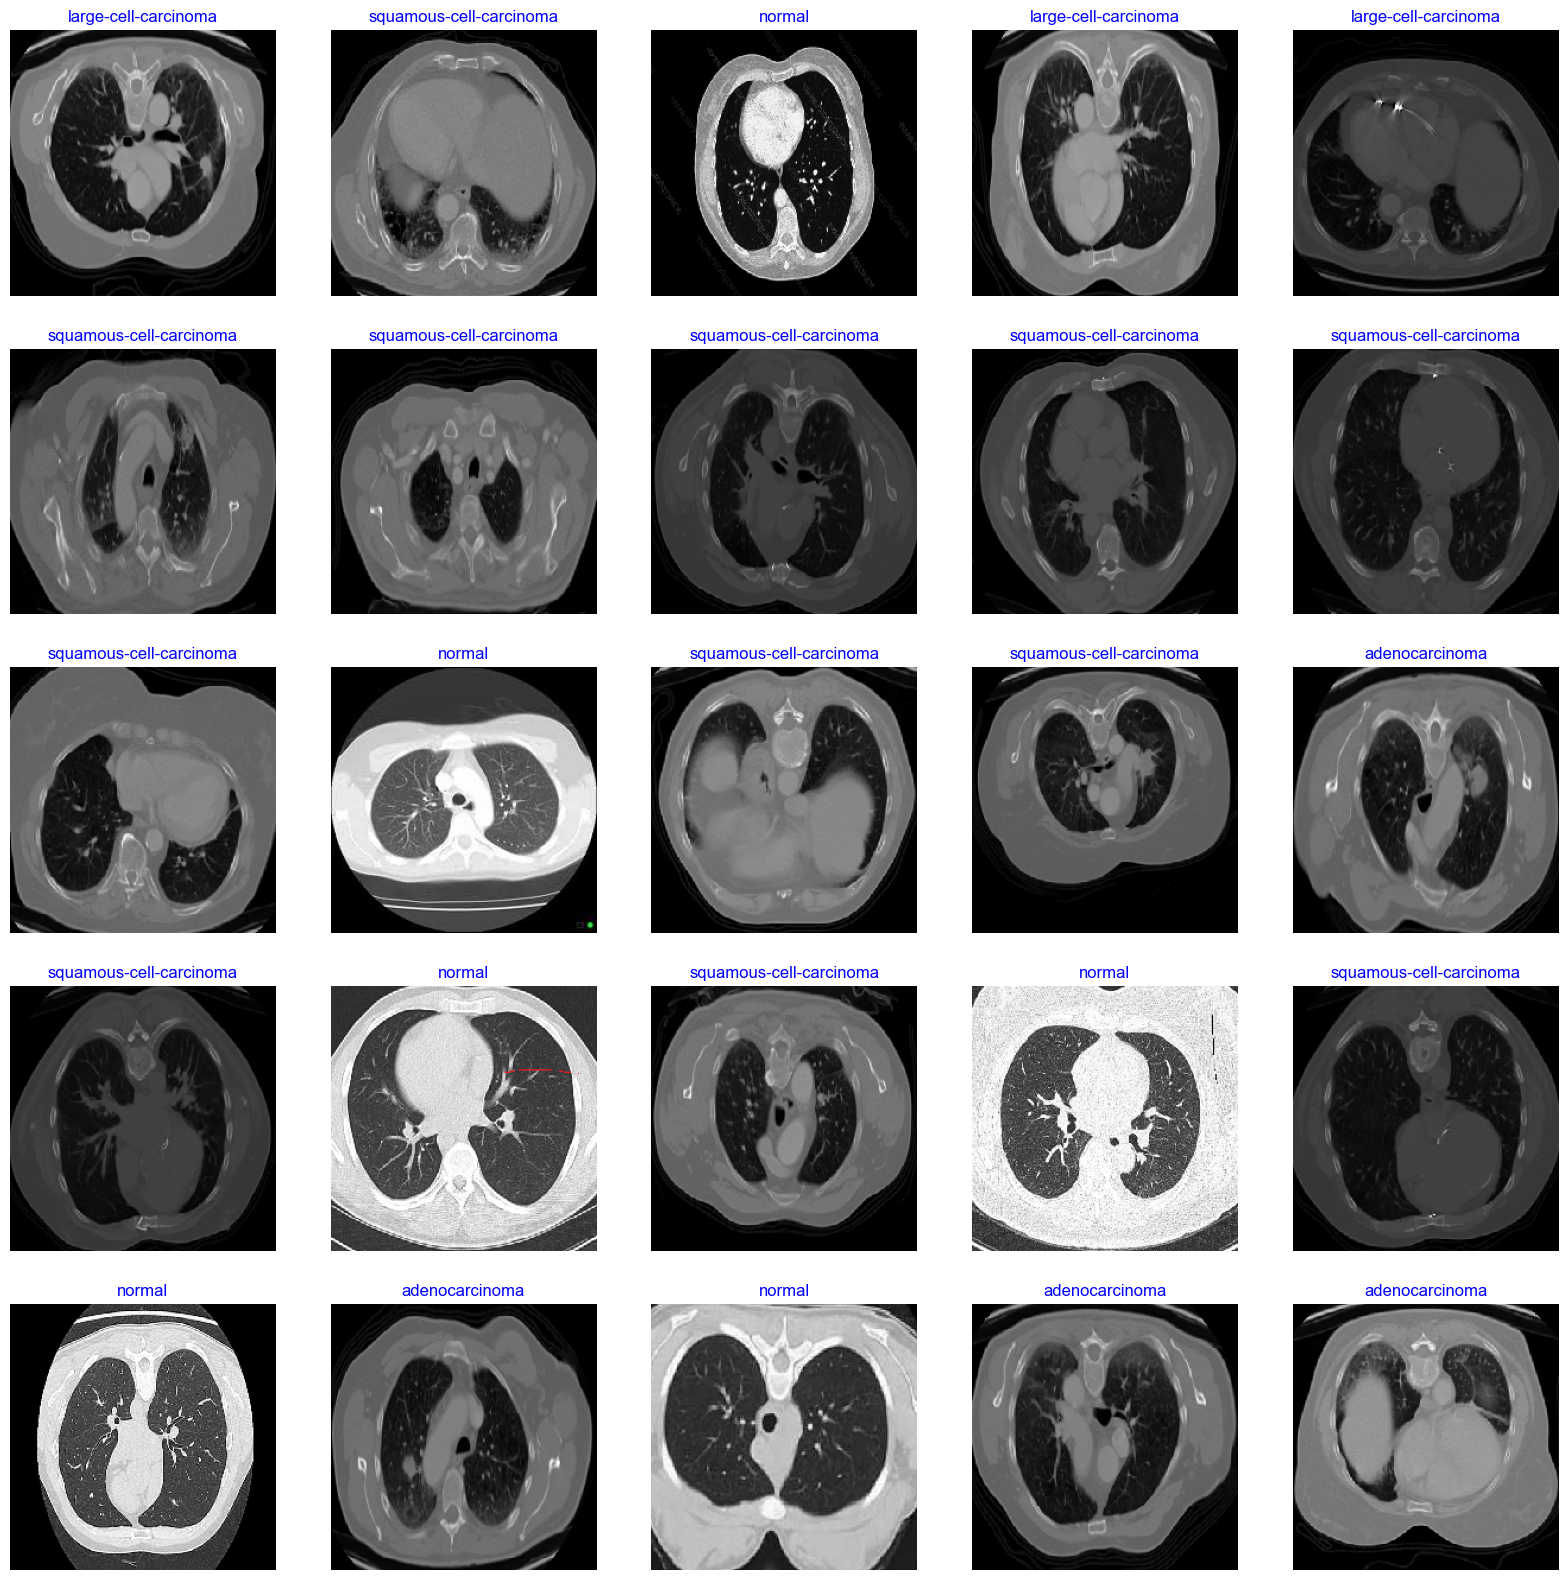

In [10]:
# Get Dataframes
train_dir ="/Users/onyekachukwuojumah/Desktop/Lung-Cancer-Detection/Data_n_experiments/train"
test_dir = "/Users/onyekachukwuojumah/Desktop/Lung-Cancer-Detection/Data_n_experiments/test"
valid_dir = "/Users/onyekachukwuojumah/Desktop/Lung-Cancer-Detection/Data_n_experiments/valid"
train_df, valid_df, test_df = create_df(train_dir, valid_dir, test_dir)

# Get Generators
batch_size = 40
train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

show_images(train_gen)

In [ ]:
def create_cnn_model():
    img_size = (224, 224)
    channels = 3
    img_shape = (img_size[0], img_size[1], channels)
    class_count = len(list(train_gen.class_indices.keys()))  

    # Build the basic CNN model
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=img_shape),
        MaxPooling2D((2, 2)),
        BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
        Flatten(),
        #same with the sequential models
        Dense(256, kernel_regularizer=regularizers.l2(l=0.016), activity_regularizer=regularizers.l1(0.006),
              bias_regularizer=regularizers.l1(0.006),activation=keras.layers.LeakyReLU(alpha=0.3)),
        Dropout(rate=0.45, seed=123),

        Dense(class_count, activation='softmax')
    ])


    model.summary()  # Print the model summary
    return model

cnn_model = create_cnn_model()


cnn_model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 111, 111, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                        

In [ ]:
def train_cnn_model(cnn_model, train_gen, valid_gen):
    batch_size = 8
    epochs = 20
    patience = 1        # number of epochs to wait to adjust lr if monitored value does not improve
    stop_patience = 3   # number of epochs to wait before stopping training if monitored value does not improve
    threshold = 0.95     # if train accuracy is < threshold adjust monitor accuracy, else monitor validation loss
    factor = 0.5        # factor to reduce lr by
    dwell = True        # experimental, if True and monitored metric does not improve on the current epoch, set model weights back to weights of the previous epoch

    ask_epoch = 15      # number of epochs to run before asking if you want to halt training
    batches = int(np.ceil(len(train_gen.labels) / batch_size))

    callbacks = [MyCallback(model=cnn_model, base_model=None,  patience=patience,
                            stop_patience=stop_patience, threshold=threshold, factor=factor,
                            dwell=dwell, batches=batches, initial_epoch=0, epochs=epochs, ask_epoch=ask_epoch)]

    history = cnn_model.fit(x=train_gen, epochs=epochs, verbose=1, callbacks=callbacks,
                        validation_data=valid_gen, validation_steps=None, shuffle=False,
                        initial_epoch=0)

    return history

cnn_history = train_cnn_model(cnn_model, train_gen, valid_gen)


 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
Epoch 1/20


2024-02-14 23:03:21.410664: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


16/16 [==============================] - ETA: 0s - loss: 31.1324 - accuracy: 0.4747 13882                     processing batch 1 of 77   -   accuracy=  41.250   -   loss: 28.71564                    processing batch 2 of 77   -   accuracy=  41.667   -   loss: 28.94449                    processing batch 3 of 77   -   accuracy=  39.375   -   loss: 34.97553                    processing batch 4 of 77   -   accuracy=  39.000   -   loss: 36.33999                    processing batch 5 of 77   -   accuracy=  41.250   -   loss: 36.68825                    processing batch 6 of 77   -   accuracy=  42.143   -   loss: 37.60370                    processing batch 7 of 77   -   accuracy=  43.125   -   loss: 36.40231                    processing batch 8 of 77   -   accuracy=  44.167   -   loss: 35.18323                    processing batch 9 of 77   -   accuracy=  44.500   -   loss: 34.56669                    processing batch 10 of 77   -   accuracy=  45.455   -   loss: 33.58397                   

2024-02-14 23:03:51.652846: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


 1 /20    31.132   47.471  506.04819 18.056   0.00100  0.00100  accuracy     0.00    31.29  
16/16 [==============================] - 31s 2s/step - loss: 31.1324 - accuracy: 0.4747 - val_loss: 506.0482 - val_accuracy: 0.1806
Epoch 2/20
16/16 [==============================] - 29s 2s/step - loss: 21.9159 - accuracy: 0.6558 - val_loss: 154.1704 - val_accuracy: 0.1667
Epoch 3/20
16/16 [==============================] - 36s 2s/step - loss: 17.1581 - accuracy: 0.6998 - val_loss: 75.4281 - val_accuracy: 0.1667
Epoch 4/20
16/16 [==============================] - 41s 3s/step - loss: 14.8018 - accuracy: 0.7749 - val_loss: 31.8576 - val_accuracy: 0.2361
Epoch 5/20
16/16 [==============================] - 36s 2s/step - loss: 12.9136 - accuracy: 0.8059 - val_loss: 16.5427 - val_accuracy: 0.4583
Epoch 6/20
16/16 [==============================] - 34s 2s/step - loss: 12.0808 - accuracy: 0.8222 - val_loss: 12.7655 - val_accuracy: 0.6667
Epoch 7/20
16/16 [==============================] - 36s 2s/step 

In [ ]:
def display_CNN_result(cnn_model, test_gen, cnn_history):
    plot_training(cnn_history)

    ts_length = len(test_gen)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length % n == 0 and ts_length / n <= 80]))
    test_steps = ts_length // test_batch_size
    train_score = cnn_model.evaluate(train_gen, steps=test_steps, verbose=1)
    valid_score = cnn_model.evaluate(valid_gen, steps=test_steps, verbose=1)
    test_score = cnn_model.evaluate(test_gen, steps=test_steps, verbose=1)

    print("Train Loss: ", train_score[0])
    print("Train Accuracy: ", train_score[1])
    print('-' * 20)
    print("Validation Loss: ", valid_score[0])
    print("Validation Accuracy: ", valid_score[1])
    print('-' * 20)
    print("Test Loss: ", test_score[0])
    print("Test Accuracy: ", test_score[1])

    preds = cnn_model.predict_generator(test_gen)
    y_pred = np.argmax(preds, axis=1)
    print(y_pred)

    target_names = ['adenocarcinoma', 'large-cell-carcinoma', 'normal', 'squamous-cell-carcinoma']
    # Confusion matrix
    cm = confusion_matrix(test_gen.classes, y_pred)
    plot_confusion_matrix(cm=cm, classes=target_names, title='Confusion Matrix')
    # Classification report
    print(classification_report(test_gen.classes, y_pred, target_names=target_names))


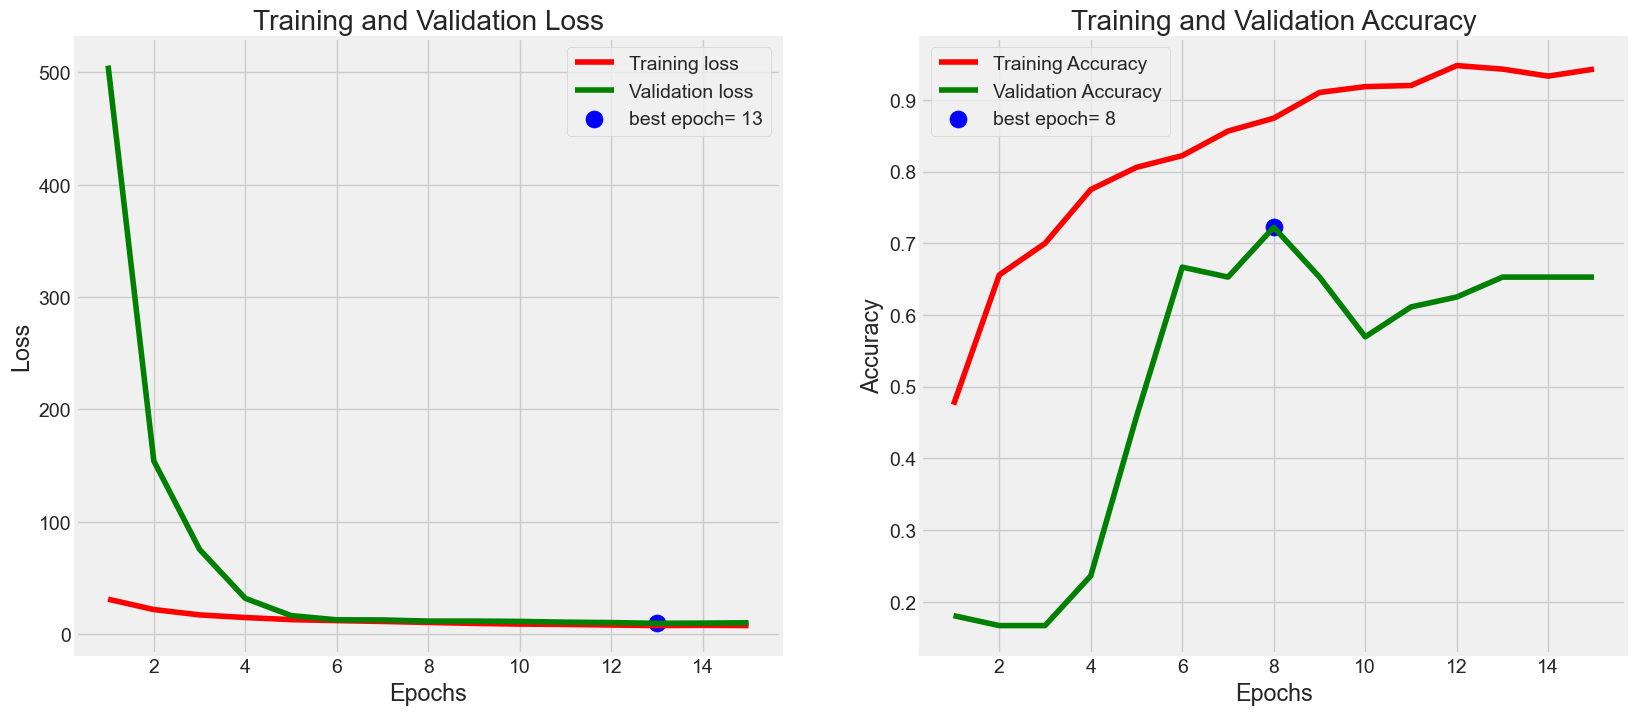

2024-02-14 23:14:13.241867: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1/1 [==============================] - 1s 860ms/step - loss: 7.9842 - accuracy: 0.8250


2024-02-14 23:14:14.348105: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1/1 [==============================] - 1s 808ms/step - loss: 11.7298 - accuracy: 0.6250


2024-02-14 23:14:15.578252: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1/1 [==============================] - 2s 2s/step - loss: 11.0748 - accuracy: 0.1746
Train Loss:  7.984200954437256
Train Accuracy:  0.824999988079071
--------------------
Validation Loss:  11.729843139648438
Validation Accuracy:  0.625
--------------------
Test Loss:  11.074760437011719
Test Accuracy:  0.1746031790971756


/var/folders/dc/65kgch5d1wjb1xx2f5yfs48h0000gn/T/ipykernel_14171/2364167199.py:20: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = cnn_model.predict_generator(test_gen)
2024-02-14 23:14:18.308249: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


[0 1 1 1 1 1 1 1 1 3 1 3 3 3 0 1 3 1 0 1 1 1 0 1 3 0 1 1 1 1 1 0 0 1 0 1 3
 1 3 1 1 0 1 0 1 1 3 1 3 1 1 3 3 1 3 3 1 1 3 1 1 1 0 1 1 3 1 1 1 1 0 3 3 1
 1 0 1 3 3 1 1 3 1 1 1 1 1 3 1 0 3 1 3 1 3 3 1 1 1 0 1 1 3 0 1 1 1 1 1 1 3
 3 1 1 1 3 3 0 0 1 1 1 1 1 1 3 0 3 3 3 3 3 1 1 0 3 3 3 3 0 1 3 1 1 1 1 3 3
 1 3 0 0 1 1 1 0 0 1 1 1 0 0 0 1 1 3 3 3 0 1 1 1 1 1 1 3 3 3 3 1 1 1 0 3 3
 1 1 3 3 0 3 1 0 3 3 0 0 1 1 1 0 3 1 0 3 1 3 1 3 0 1 3 1 1 1 1 1 3 1 1 1 3
 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 3 1 1 1 1 1 1 3 3 1 1 1 3 3 3
 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2
 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
Confusion Matrix, Without Normalization
[[18 71  0 31]
 [ 0 40  0 11]
 [ 1  1 52  0]
 [19 39  0 32]]
                         precision    recall  f1-score   support

         adenocarcinoma       0.47      0.15      0.23       120
   large-cell-carcinoma       0.26      0.78      0.40        51
                 normal       1.00      0.96      0.98        5

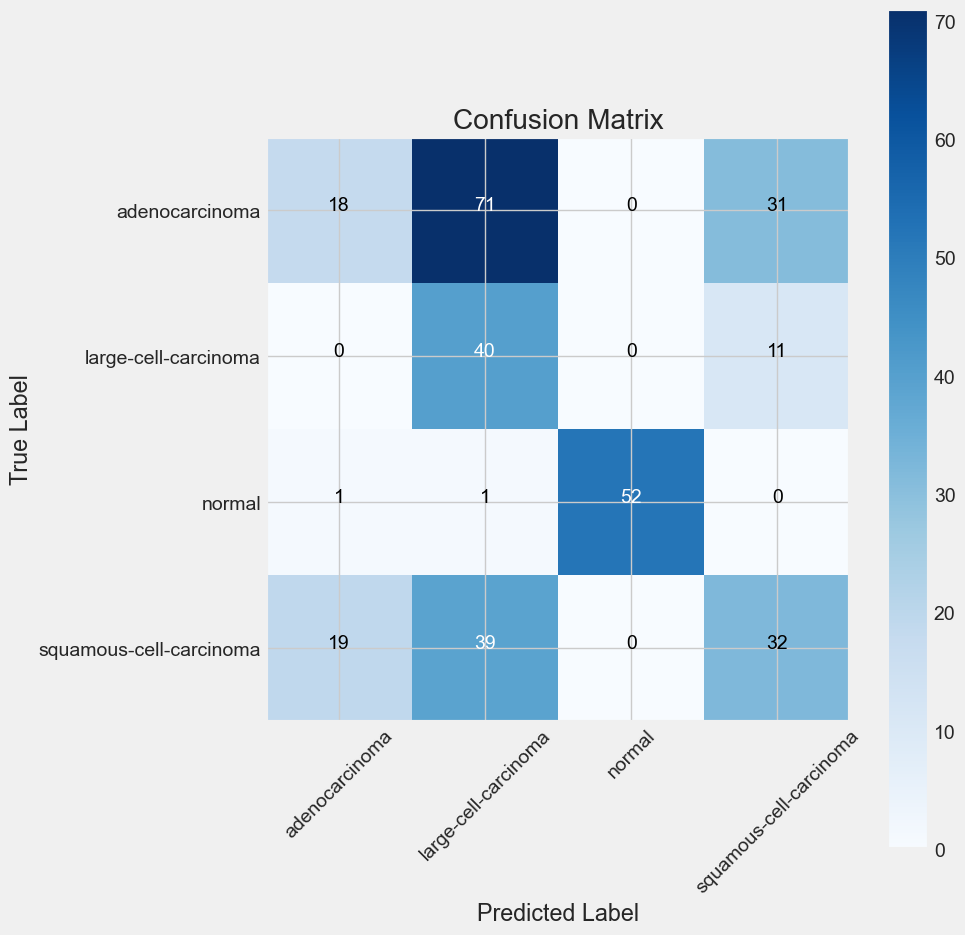

In [ ]:
display_CNN_result(cnn_model, test_gen, cnn_history)